#### read into the images and caculate the stddev. Taking parts of an image and try out the slide

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'
import pandas as pd
import random
import glob
from skimage import io

In [2]:
# path = 'F:\LM\digitalConfocal\data\interim\zebra_fish'
path = 'F:\Data\LM'

In [3]:
def readTIF(data_path):
    images = []
    for img in glob.glob(os.path.join(data_path, "*.tif")):
        
        im = io.imread(os.path.join(data_path, img))  
        imarray = np.array(im)
        images.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(images)

In [4]:
rawData = readTIF(path)  # multiple stacks, each contains two channels, each channel 20 imgs
rawGray = rawData[:,:,1,...]  # gray channel
X, Y = rawGray.shape[2], rawGray.shape[3]   # original size of images

In [5]:
# # sanity check

# test1 = rawData[0,...]
# testGray = test1[:,1,...]
# exmpSlice = testGray[10,...]

# plt.imshow(exmpSlice, cmap='gray')

#### one slice for feature map calculation。 尝试用现成的包去实现

In [6]:
# data

testStack = rawGray[0,...]
testSlice = testStack[0,...]  # target slice

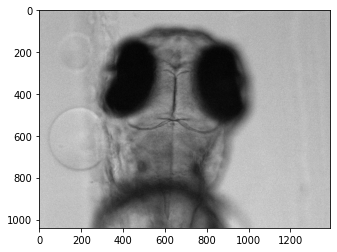

In [7]:
plt.imshow(testSlice, cmap='gray')

In [8]:
# 测试基础从npy读取图片的过程
image = np.load('F:/LM/digitalConfocal/notebooks/testIMG.npy')

image = np.stack((image,)*3, axis=-1)

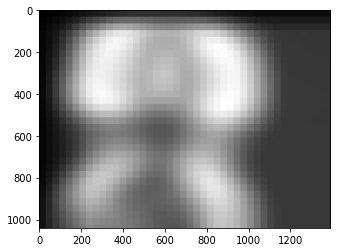

In [25]:
# 读取基础的写入的文件

test = image.shape[:2]
test1 = np.zeros((test))

test2 =  np.load('stdMap.npy')
plt.imshow(test2, cmap='gray')

In [21]:
print(test2.shape)

(1040, 1392)


#### 测试单个的计算的函数、

In [23]:
test31 = image[:100, :100, 0]

In [24]:
test3 =  test2[:100, :100]

print(test31)
print(test3)

[[36 35 32 ... 34 36 36]
 [31 38 32 ... 39 32 39]
 [33 34 37 ... 32 33 38]
 ...
 [34 39 37 ... 35 36 36]
 [34 33 34 ... 39 36 35]
 [37 36 35 ... 32 32 35]]
[[ 13.57876071  13.57876071  13.57876071 ...  52.81086779  52.81086779
   52.81086779]
 [ 13.57876071  13.57876071  13.57876071 ...  52.81086779  52.81086779
   52.81086779]
 [ 13.57876071  13.57876071  13.57876071 ...  52.81086779  52.81086779
   52.81086779]
 ...
 [ 54.20697997  54.20697997  54.20697997 ... 209.57508117 209.57508117
  209.57508117]
 [ 54.20697997  54.20697997  54.20697997 ... 209.57508117 209.57508117
  209.57508117]
 [ 54.20697997  54.20697997  54.20697997 ... 209.57508117 209.57508117
  209.57508117]]


In [7]:
# patch the image

from patchify import patchify, unpatchify

# def patchSlice(img, ratio, gcdNum):
#     patchSize = {'x': int(ratio*gcdNum), 'y': int(ratio*gcdNum), 'step':int(ratio*gcdNum)}  # gcd is 16
#     tempPatch = patchify(img, (patchSize['x'], patchSize['y']), step = patchSize['step'])
#     unpatchPara = tempPatch.shape
#     tempPatch = np.reshape(tempPatch, (-1, tempPatch.shape[2], tempPatch.shape[3]))
#     return tempPatch, unpatchPara

def patchSlice(img, steps):
    patchSize = {'x': int(steps), 'y': int(steps), 'step':int(steps)}  # gcd is 16
    tempPatch = patchify(img, (patchSize['x'], patchSize['y']), step = patchSize['step'])
    unpatchPara = tempPatch.shape
    tempPatch = np.reshape(tempPatch, (-1, tempPatch.shape[2], tempPatch.shape[3]))
    return tempPatch, unpatchPara

In [8]:
# calculate the feature map

def featureMap(batches, unpatchPara, X, Y):
    
    fMap = []
    for i in range(batches.shape[0]):
        tempP = batches[i,...]
        featureP = np.ones((tempP.shape)) * np.std(tempP)
#         print(np.std(tempP))
        fMap.append(featureP)
        
    fMap = np.reshape(np.asarray(fMap),
                    (unpatchPara[0], unpatchPara[1],
                     unpatchPara[2], unpatchPara[3]))
    fMap = unpatchify(fMap, (X,Y)) # resize back to the original size
    
#     fScale = np.interp(fMap, (fMap.min(), fMap.max()), (0, 1))
    return fMap
        

In [10]:
import math
import primefac
from sympy import divisors

gcdNum = math.gcd(X, Y)
factors = divisors(gcdNum)
testFac = [32, 64]

#### demo on the part of the image

In [11]:
# take a part of the image

testArea = testSlice[:,0:200]

In [15]:
# patch in random size and step width
tempPatch = patchify(testArea, (200, 200), step = 200)


from skimage.util import view_as_windows
window_shape = (200, 200)
skiPatches = view_as_windows(testArea, window_shape=window_shape, step=200)

In [18]:
# sliding the window

# import the necessary packages
import imutils
def pyramid(image, scale=1.5, minSize=(30, 30)):
	# yield the original image
	yield image
	# keep looping over the pyramid
	while True:
		# compute the new dimensions of the image and resize it
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])


In [20]:
# sliding window for object detection
import argparse
import time
import cv2

# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True, help="Path to the image")
# args = vars(ap.parse_args())
# load the image and define the window width and height
# image = cv2.imread(args["image"])
image = testSlice
(winW, winH) = (128, 128)

In [21]:
for resized in pyramid(image, scale=1.5):
	# loop over the sliding window for each layer of the pyramid
	for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
		# if the window does not meet our desired window size, ignore it
		if window.shape[0] != winH or window.shape[1] != winW:
			continue
		# THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
		# MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
		# WINDOW
		# since we do not have a classifier, we'll just draw the window
		clone = resized.copy()
		cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
		cv2.imshow("Window", clone)
		cv2.waitKey(1)
		time.sleep(0.025)

In [22]:
np.save('testIMG.npy', testSlice)

In [ ]:
fMap = []

for i in range(len(factors)):
    tempPatch, tempPara = patchSlice(testSlice, factors[i])
    tempMap = featureMap(tempPatch, tempPara, X, Y)
#     plt.figure()
#     plt.imshow(tempMap, cmap='gray')
    fMap.append(tempMap)

[[2.54950976 2.54950976 0.8660254  ... 2.58602011 3.83242743 3.83242743]
 [2.54950976 2.54950976 0.8660254  ... 2.58602011 3.83242743 3.83242743]
 [1.47901995 1.47901995 1.47901995 ... 1.80277564 1.22474487 1.22474487]
 ...
 [2.27760839 2.27760839 1.92028644 ... 2.5        1.08972474 1.08972474]
 [2.58602011 2.58602011 2.06155281 ... 3.63145976 1.58113883 1.58113883]
 [2.58602011 2.58602011 2.06155281 ... 3.63145976 1.58113883 1.58113883]]


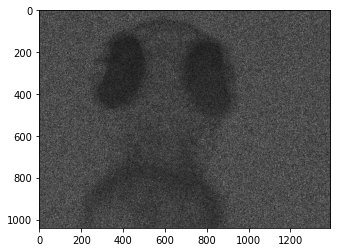

In [24]:
test1 = fMap[1]
print(test1)
plt.imshow(test1, cmap='gray')

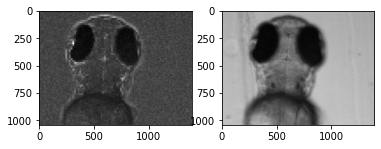

In [23]:
fMax = np.max(np.asarray(fMap), axis=0)
plt.subplot(1,2,1)
plt.imshow(fMax, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(testSlice, cmap='gray')
plt.show()

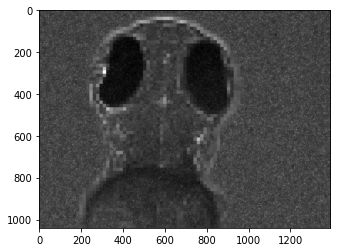

In [24]:
fScale = np.interp(fMax, (fMax.min(), fMax.max()), (0, 1))
plt.imshow(fScale, cmap='gray')

In [15]:
print(np.max(fMax), np.min(fMax))

1.1189002932392758

In [ ]:
temp1, para1 = patchSlice(testSlice, 1, gcdNum)
temp2, para2 = patchSlice(testSlice, 0.5, gcdNum)

In [ ]:
testMap1 = featureMap(temp1, para1, X, Y)
plt.imshow(testMap1, cmap='gray')

In [ ]:
testMap2 = featureMap(temp2, para2, X, Y)
plt.imshow(testMap2, cmap='gray')

In [ ]:
# stack the images together and get max projection
fStack = []# np.stack(())
fStack.append(testMap1)
fStack.append(testMap2)
fTestStack = np.asarray(fStack)


In [ ]:
fMax= np.max(fTestStack, axis=0)
plt.imshow(fMax, cmap='gray')

#### patchify and processing. results store in the dict, be careful about the patch number and slice number.

In [ ]:
from patchify import patchify, unpatchify

def stdStack(stack, patchSize):
    stackDev = [] # dev for one stack
    stackPatch = []
    for i in range(stack.shape[0]):
        temp = stack[i,...]  
        tempPatch = patchify(temp, (patchSize['x'], patchSize['y']), step = patchSize['step'])
        unpatchPara = tempPatch.shape  # for later unpatchify. document the parma before flatten
        tempPatch = np.reshape(tempPatch, (-1, tempPatch.shape[2], tempPatch.shape[3]))
        sliceDev = []  # Dev for every slice
        for j in range(tempPatch.shape[0]):
            sliceDev.append(np.std(tempPatch[j,...]))
            
        stackDev.append(sliceDev)
        stackPatch.append(tempPatch)
        
    return np.asarray(stackPatch), np.asarray(stackDev), unpatchPara

In [ ]:
import math
gcdNum = math.gcd(X, Y)

In [ ]:
testStack = rawGray[0,...]
N = 1
patchSize = {'x': N*gcdNum, 'y': N*gcdNum, 'step':N*gcdNum}  # gcd is 16
stackPatch, stackDev, unPatch = stdStack(testStack, patchSize)

In [ ]:
# search for the same stddev in one stack

stackDevRound = np.around(stackDev,2) # keep the precision
# stackDevRound = np.rint(stackDev)  # only keeps integer
a = np.unique(stackDevRound, return_counts=True)
a = np.asarray(a)
# print(a[1, 100:200])
plt.figure(); plt.grid(); plt.plot(a[1,:])  # frequency of certain patches 
# plt.figure(); plt.grid(); plt.plot(a[0,:]) 

In [ ]:
print(min(a[0,:]), max(a[0,:]))

In [ ]:
# get the average of the images

testMean = testStack.sum(axis=0) / 200
testMean = testMean.astype('uint8')
# sanity check the embedding images
plt.figure();plt.imshow(testMean, cmap='gray')
plt.figure();plt.imshow(testStack[10,...], cmap='gray')

In [ ]:
# # 测试基础的Patch和unpatchify

# import math
# from patchify import patchify, unpatchify

# gcdNum = math.gcd(X, Y)

# patchSize = {'x': 8, 'y': 8, 'step':8}
# exmpPatch = patchify(exmpSlice, (patchSize['x'], patchSize['y']), step = patchSize['step']) # 2D patches 
# input_patch = np.reshape(exmpPatch, (-1, exmpPatch.shape[2], exmpPatch.shape[3]))


# # unpatchify the small patches
# output_patch_reshaped = np.reshape(input_patch, 
#                                         (exmpPatch.shape[0], exmpPatch.shape[1],
#                                          exmpPatch.shape[2],exmpPatch.shape[3]) )

# unpatchImg = unpatchify(output_patch_reshaped, (X,Y))


In [ ]:
# # debug dev 算出来都一样

# stack = testStack

# stackDev = [] # dev for one stack
# stackPatch = []
# temp = stack[0,...]
# tempPatch = patchify(temp, (patchSize['x'], patchSize['y']), step = patchSize['step'])
# tempPatch1 = np.reshape(tempPatch, (-1, tempPatch.shape[2], tempPatch.shape[3]))

# sliceDev = []
# for j in range(tempPatch1.shape[0]):
#     tempDev = 
#     sliceDev.append(np.std(tempPatch1[j,...]))


In [ ]:
class MyDataset(Dataset):
    def __init__(self, dataPath, maskPath, patchSize, seedNum):
        
        self.patchSize = patchSize
        self._seedNum = seedNum
        
        with mrcfile.open(dataPath) as mrc:  # 获取数据
            self.data = mrc.data.transpose(1,2,0)
            x = patchify(self.data, (self.patchSize['x'],self.patchSize['y'],self.patchSize['z']), step=self.patchSize['step'])
            self._x = np.reshape(x, (-1, x.shape[3], x.shape[4], x.shape[5]))
            del x

        with mrcfile.open(maskPath) as mrc:  
            self.mask = mrc.data.transpose(1,2,0) 
            y = patchify(self.mask, (self.patchSize['x'],self.patchSize['y'],self.patchSize['z']), step=self.patchSize['step'])
            self._y = np.reshape(y, (-1, y.shape[3], y.shape[4], y.shape[5]))
            del y
            
        self._len = self.data.shape

    def __getitem__(self, index):
        # 获得一一对应的关系
        np.random.seed(self._seedNum)

        return self._x[index], self._y[index]
        
    def __len__(self):
        return len(self._x)

In [ ]:
patchSize = {'x': 64, 'y': 64, 'step':64}
test = MyDataset(focalPath, focalPath, patchSize, 100)